<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Test-LCAS" data-toc-modified-id="Test-LCAS-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Test LCAS</a></span></li><li><span><a href="#Test-Own-Data" data-toc-modified-id="Test-Own-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Test Own Data</a></span></li><li><span><a href="#Summary-of-frame:" data-toc-modified-id="Summary-of-frame:-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Summary of frame:</a></span></li></ul></li><li><span><a href="#Validate-Annotations" data-toc-modified-id="Validate-Annotations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Validate Annotations</a></span></li><li><span><a href="#Calculate-Bounding-Box" data-toc-modified-id="Calculate-Bounding-Box-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate Bounding Box</a></span><ul class="toc-item"><li><span><a href="#Source-code" data-toc-modified-id="Source-code-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Source code</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Orientation-angle" data-toc-modified-id="Orientation-angle-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Orientation angle</a></span></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualizations</a></span><ul class="toc-item"><li><span><a href="#Using-Mayavi" data-toc-modified-id="Using-Mayavi-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Using Mayavi</a></span><ul class="toc-item"><li><span><a href="#Source-code" data-toc-modified-id="Source-code-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Source code</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Using-Matplotlib" data-toc-modified-id="Using-Matplotlib-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Using Matplotlib</a></span><ul class="toc-item"><li><span><a href="#source-code" data-toc-modified-id="source-code-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>source code</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Testing</a></span></li></ul></li></ul></li><li><span><a href="#Validation-Pipeline" data-toc-modified-id="Validation-Pipeline-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Validation Pipeline</a></span></li><li><span><a href="#Data-Overview" data-toc-modified-id="Data-Overview-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Data Overview</a></span></li><li><span><a href="#Backup" data-toc-modified-id="Backup-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Backup</a></span><ul class="toc-item"><li><span><a href="#Create-PCD-Files" data-toc-modified-id="Create-PCD-Files-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Create PCD Files</a></span></li><li><span><a href="#Visualizations" data-toc-modified-id="Visualizations-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Visualizations</a></span><ul class="toc-item"><li><span><a href="#3D-Plot-using-matplotlib" data-toc-modified-id="3D-Plot-using-matplotlib-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>3D Plot using matplotlib</a></span></li><li><span><a href="#3D-Plot-using-pptk" data-toc-modified-id="3D-Plot-using-pptk-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>3D Plot using pptk</a></span></li></ul></li></ul></li></ul></div>

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import string
import numpy as np
import math
import matplotlib.pyplot as plt 
import pandas as pd
import time
import collections
import seaborn as sns 
# import pcl
import ipywidgets as widgets
from IPython.display import display
import h5py

from crowd_tracker_lidar3d.loader import load_data_to_dataframe
from crowd_tracker_lidar3d.plot_tools import plot_pointcloud3d, draw_point_cloud, show_projections
from crowd_tracker_lidar3d.preprocessing import rotate_pcl, df_apply_rot, return_ground_points, \
                                                remove_ground_points, standardize_data, translate_height,\
                                                add_polar_coord, rotate_pcl
from crowd_tracker_lidar3d.cluster_utils import return_cluster_and_noise_points, plot_xy_cluster_results, \
                                                plot_3d_cluster_results
from crowd_tracker_lidar3d.hdf5_util import load_h5, load_h5_basic
from crowd_tracker_lidar3d.annotation_utils import calc_heading_angle
import matplotlib.pyplot as plt 

In [13]:
# Helper Function to save plots 
def save_fig(fig, path, extension='.pdf'):
    save_dir = path + extension
    fig.savefig(save_dir, bbox_inches='tight')  

## Load Data

In [22]:
os.getcwd()
DATA_DIR = os.path.dirname(os.path.abspath(''))

### Test LCAS 

In [79]:
def get_label_file(frame, label_dir, data_dir):
    frame_name = frame.split('.')[0]
    # print(frame_name)
    frame_idx = int(frame_name.replace('frame',''))
    idx_map_file = os.path.join(data_dir, 'idx_map.txt')
    idx_map = {}
    with open(idx_map_file, 'r') as file:
        lines = file.readlines()
        for line in lines: 
            idx, name = line.strip().split(':')
            idx_map[int(idx)] = name
    # check if frame annotated
    label_path = os.path.join(label_dir, idx_map[frame_idx]+'.txt') 
    return label_path

In [80]:
def get_annotated_frames(label_dir):
    annot_file = os.path.join(label_dir, 'annotated_frames.txt')
    idx_map = {}
    with open(annot_file, 'r') as file:
        lines = file.readlines()
        for line in lines: 
            idx, name = line.strip().split(':')
            idx_map[int(idx)] = name
    return idx_map

In [145]:
def get_data_and_labels(idx, data_dir, label_dir,verbose=False): 
    annot_idx_map = get_annotated_frames(label_dir)
    frame_ids = list(annot_idx_map.keys())
    frame_id = frame_ids[idx]
    file_name = 'frame{}.h5'.format(frame_id)
    data = load_h5_basic(os.path.join(data_dir, file_name))
    bboxes = load_h5_basic(os.path.join(label_dir, file_name))
    if verbose:
        print('Frame has {} points and {} object(s).'.format(data.shape[0], bboxes.shape[0]))
    return data,bboxes

In [169]:
sequence = '1239_1256'
data_dir = os.path.join(DATA_DIR, "data/LCAS/hdf5/{}/".format(sequence))
label_dir = os.path.join(DATA_DIR, "data/LCAS/annotated_boundbox/{}/".format(sequence))
label = None 

In [170]:
data, bboxes = get_data_and_labels(50, data_dir, label_dir, verbose=True)

Frame has 26505 points and 8 object(s).


In [139]:
dets = 0 
for idx in frame_ids: 
    data, bboxes = get_data_and_labels(idx, data_dir, label_dir)
print('Average detections per scene: {}'.format(float(dets)/float(len(frame_ids))))

Average detections per scene: 1.6740713765477058


In [160]:
corners3d_boxes = boxes3d_to_corners3d_velodyne(bboxes,rotate=True)

### Test Own Data

In [15]:
DATA_DIR = os.path.join(DATA_DIR, "data/med/annotated_boundbox/filtered_wo_floor")
print(DATA_DIR)

/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/data/med/annotated_boundbox/filtered_wo_floor


In [24]:
for folder in sorted(os.listdir(DATA_DIR)):
    print(folder)
    path = os.path.join(DATA_DIR, folder) 
    data_files = [str(f) for f in sorted(os.listdir(path)) if f.endswith('.h5')] 
    break

person166_1


In [54]:
# dist = int(folder.split('_')[-1])
dist = 3
# f = '/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/data/med/annotated_boundbox/unfiltered/person170_3/frame54.h5'
# f = '/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/data/med/annotated_boundbox/unfiltered/walk_person185_1/frame160.h5'
f = '/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/data/med/annotated_boundbox/unfiltered/walk_person185_6/frame389.h5'

# f = '/home/crowdbot/master_lara/catkin_ws/src/crowd_tracker_lidar3d/data/med/annotated_boundbox/filtered_wo_floor/person166_{}/frame116.h5'.format(dist)
data, label, bboxes = load_h5(f, bbox=True)
bboxes = np.reshape(bbox, (-1,7))
print(data.shape, label.shape, bboxes.shape)

(8487, 4) (8487,) (7,)


In [55]:
data[:, 0:3]
for dim in range(0, data.shape[1]): 
    print(np.min(data[:, dim]), np.max(data[:, dim]))

-4.1941314 41.580185
-36.972237 35.75776
-0.492425 4.3274508
0.48 115.48


### Summary of frame: 

In [171]:
for box in bboxes: 
    centroid, h, w, l, angle = box[0:3], box[3], box[4], box[5], box[6]
    print('--------------\nBox parameters: \n\ncentroid {}\nheight {}\nlength {}\angle{}\n'.format(centroid, h,w,l,angle))

if label: 
    mask = np.where(label)
    template = data[mask]
    background_mask = np.where(~label)
    print('Bounding box dimensions:\n {}'.format(bbox))
    print('Human template comprising {} points.'.format(template.shape[0]))

--------------
Box parameters: 

centroid [4.32382   1.19829   0.0958688]
height 1.4155880212783813
length 0.589900016784668ngle0.652180016040802

--------------
Box parameters: 

centroid [-0.520362   2.15718    0.0313196]
height 1.3506139516830444
length 0.5214890241622925ngle0.47284001111984253

--------------
Box parameters: 

centroid [-1.96377   2.05597   0.105498]
height 1.4739569425582886
length 0.6302800178527832ngle0.5539299845695496

--------------
Box parameters: 

centroid [-1.10456    1.71837    0.0328268]
height 1.286944031715393
length 0.5977489948272705ngle0.6176000237464905

--------------
Box parameters: 

centroid [-17.6257    -0.788333   0.102555]
height 0.7208520174026489
length 0.41110000014305115ngle0.6448609828948975

--------------
Box parameters: 

centroid [-3.28167   -2.94146   -0.0591346]
height 0.7329739928245544
length 0.5920000076293945ngle0.6244000196456909

--------------
Box parameters: 

centroid [ 0.656262 -6.18678  -0.051729]
height 0.966323

## Validate Annotations

Find outliers in positively labeled point segments, because they can influence the box dimensions (i.e. height, width, length). Outlier search based on k-nearest neighbor distance score. Threshold found by trial and error. 

In [59]:
from sklearn.neighbors import NearestNeighbors
from pyod.models.knn import KNN   # kNN detector
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import NearestNeighbors

final_data = data
print('Number of points: {}'.format(data.shape[0]))

# filter data for only positive labels and do bbox calculations only on mask
mask = np.where(label) 
filter_data = final_data[mask]
print('Template Points: {}'.format(len(filter_data)))

# remove floor points from data 
ground_mask = np.where(filter_data[:,2] >= 0)
filter_data = filter_data[ground_mask]

nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(filter_data[:,:2])
distances, indices = nbrs.kneighbors(filter_data[:,:2])
mean_dists = distances.mean(axis=1)
print('Mean avg dist. to 5 closest neighbors: {}'.format(np.round(np.mean(mean_dists),decimals=4)))

outlier_mask = np.where(mean_dists>0.1)
inlier_mask = np.where(mean_dists<=0.1)
print('Number of detected outliers:{}'.format(len(outlier_mask[0])))
outliers = filter_data[outlier_mask]
filter_data = filter_data[inlier_mask]
    
# calculate centroid from pointcloud only using spatial coordinates
centroid = filter_data[:,:3].mean(axis=0)

min_x, min_y, min_z = np.min(filter_data[:,0]), np.min(filter_data[:,1]), np.min(filter_data[:,2])
max_x, max_y, max_z = np.max(filter_data[:,0]), np.max(filter_data[:,1]), np.max(filter_data[:,2])

# create bounding box parameters (h,w,l)
h = max_z - 0 # assume that legs always on ground  
w = max_x - min_x
l = max_y - min_y

centroid[2] = h/2

# enlarge bbox by a small constant 
const = 0.1
h = h + const 
w = w + const 
l = l + const 

# Compute orientation 
orient_angle, pca = calc_heading_angle(filter_data, label)
# pca_stats = [pca['mean'], pca['components']]

bbox = np.concatenate((centroid, (h,w,l), ([orient_angle])))
gt_box = np.reshape(bbox, (-1,7))
corners3d_box = boxes3d_to_corners3d_velodyne(gt_box)

Number of points: 8487
Template Points: 91
Mean avg dist. to 5 closest neighbors: 0.0888
Number of detected outliers:27


In [48]:
outlier_mask[0]

array([646, 647, 648])

## Calculate Bounding Box 

### Source code

In [16]:
def calc_3d_box(bbox): 
    x, y, z, h, w, l = bbox[:6]
    box8 = np.array(
        [
            [
                x + w / 2,
                x + w / 2,
                x - w / 2,
                x - w / 2,
                x + w / 2,
                x + w / 2,
                x - w / 2,
                x - w / 2,
            ],
            [
                y - l / 2,
                y + l / 2,
                y + l / 2,
                y - l / 2,
                y - l / 2,
                y + l / 2,
                y + l / 2,
                y - l / 2,
            ],
            [
                z - h / 2,
                z - h / 2,
                z - h / 2,
                z - h / 2,
                z + h / 2,
                z + h / 2,
                z + h / 2,
                z + h / 2,
            ],
        ]
    )
    return box8.T

In [17]:
def draw_gt_boxes3d(
    gt_boxes3d,
    fig,
    color=(1, 1, 1),
    line_width=1,
    draw_text=False,
    text_scale=(1, 1, 1),
    color_list=None,
    label=""
):
    """ Draw 3D bounding boxes in mayavi
    Args:
        gt_boxes3d: numpy array (n,8,3) for XYZs of the box corners
        fig: mayavi figure handler
        color: RGB value tuple in range (0,1), box line color
        line_width: box line width
        draw_text: boolean, if true, write box indices beside boxes
        text_scale: three number tuple
        color_list: a list of RGB tuple, if not None, overwrite color.
    Returns:
        fig: updated fig
    """
    num = len(gt_boxes3d)
    for n in range(num):
        b = gt_boxes3d[n]
        if color_list is not None:
            color = color_list[n]
        if draw_text:
            mlab.text3d(
                b[4, 0],
                b[4, 1],
                b[4, 2],
                label,
                scale=text_scale,
                color=color,
                figure=fig,
            )
        for k in range(0, 4):
            # http://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html
            i, j = k, (k + 1) % 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )

            i, j = k + 4, (k + 1) % 4 + 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )

            i, j = k, k + 4
            mlab.plot3d(
                [b[i, 0], b[j, 0]],
                [b[i, 1], b[j, 1]],
                [b[i, 2], b[j, 2]],
                color=color,
                tube_radius=None,
                line_width=line_width,
                figure=fig,
            )
    # mlab.show(1)
    # mlab.view(azimuth=180, elevation=70, focalpoint=[ 12.0909996 , -1.04700089, -2.03249991], distance=62.0, figure=fig)
    return fig

In [18]:
def generate_corners3d(pos,h,w,l,rz):
    """
    Generate corners3d representation (oriented bounding box representation) for this object
    :h,w,l bounding box dimensions 
    :rz rotation angle around z-axis in velodyn coord. (-pi, pi)
        7 -------- 6
       /|         /|
      4 -------- 5 .
      | |        | |
      . 3 -------- 2
      |/         |/
      0 -------- 1
    :return corners_3d: (8, 3) corners of oriented box3d in Velodyne coord.
    """
    # careful: width, length and height have been differently defined than in KITTI
    x_corners = [w / 2, w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2]        
    y_corners = [-l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2]
    z_corners = [-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]

    # rotation now defined in Velodyne coords. -> around z-axis => yaw rot. 
    R = np.array([[np.cos(rz), -np.sin(rz), 0],
                  [np.sin(rz), np.cos(rz), 0],
                  [0, 0, 1]])
    corners3d = np.vstack([x_corners, y_corners, z_corners])  # (3, 8)
    # transpose and rotate around orientation angle 
    corners3d = np.dot(R, corners3d).T
    corners3d = corners3d + pos
    return corners3d

In [19]:
def boxes3d_to_corners3d_velodyne(boxes3d, rotate=True):
    """
    :param boxes3d: (N, 7) [x, y, z, h, w, l, ry]
    :param rotate:
    :return: corners3d: (N, 8, 3)
    """

    boxes_num = boxes3d.shape[0]
    h, w, l = boxes3d[:, 3], boxes3d[:, 4], boxes3d[:, 5]
    x_corners = np.array([w / 2., w / 2., -w / 2., -w / 2., w / 2., w / 2., -w / 2., -w / 2.], dtype=np.float32).T  # (N, 8)
    y_corners = np.array([-l / 2., l / 2., l / 2., -l / 2., -l / 2., l / 2., l / 2., -l / 2.], dtype=np.float32).T  # (N, 8)
    z_corners = np.array([-h / 2., -h / 2., -h / 2., -h / 2., h / 2., h / 2., h / 2., h / 2.], dtype=np.float32).T  # (N, 8)

    if rotate:
        rz = boxes3d[:, 6]
        zeros, ones = np.zeros(rz.size, dtype=np.float32), np.ones(rz.size, dtype=np.float32)
        rot_list = np.array([[np.cos(rz), np.sin(rz), zeros],
                             [-np.sin(rz), np.cos(rz), zeros],
                             [zeros, zeros,  ones]])  # (3, 3, N)
        R_list = np.transpose(rot_list, (2, 0, 1))  # (N, 3, 3)

        temp_corners = np.concatenate((x_corners.reshape(-1, 8, 1), y_corners.reshape(-1, 8, 1),
                                       z_corners.reshape(-1, 8, 1)), axis=2)  # (N, 8, 3)
        rotated_corners = np.matmul(temp_corners, R_list)  # (N, 8, 3)
        x_corners, y_corners, z_corners = rotated_corners[:, :, 0], rotated_corners[:, :, 1], rotated_corners[:, :, 2]

    x_loc, y_loc, z_loc = boxes3d[:, 0], boxes3d[:, 1], boxes3d[:, 2]

    x = x_loc.reshape(-1, 1) + x_corners.reshape(-1, 8)
    y = y_loc.reshape(-1, 1) + y_corners.reshape(-1, 8)
    z = z_loc.reshape(-1, 1) + z_corners.reshape(-1, 8)

    corners = np.concatenate((x.reshape(-1, 8, 1), y.reshape(-1, 8, 1), z.reshape(-1, 8, 1)), axis=2)

    return corners.astype(np.float32)

### Testing

In [92]:
# Apprach 1: 
corners3d_box = boxes3d_to_corners3d_velodyne(bboxes)

In [28]:
# Approach 2: - should lead to same result as approach 1 
centroid, h, w, l, rz = bbox[0:3], float(bbox[3]), float(bbox[4]), float(bbox[5]), float(bbox[6])
corners3d_box = generate_corners3d(centroid,h,w,l,rz)
corners3d_box = np.reshape(corners3d_box, (-1,8,3))

In [30]:
# Evaluate deviation from predefined standard pedestrian template anchor box 
anchor = [1.73, 0.6, 0.8] # h,w,l
res_h = np.abs(h - anchor[0])
res_w = np.abs(w - anchor[1])
res_l = np.abs(l - anchor[2])
print(res_h, res_w, res_l)
print(np.sum([res_h, res_w, res_l]))

0.4114228296279907 0.8755762815475464 0.5832312822341919
1.8702303934097289


## Orientation angle 
Look for principal component in x,y-plane. Eigenvalues of covariance matrix = principle components $\rightarrow$ eigenvector with largest eigenvalue of the covariance matrix = direction along which data has the largest variance.

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [32]:
def calc_heading_angle(data, label_mask): 
    """ Calculate object rotation in Velodyne coordinates, i.e. the yaw angle, assmuing the other 
        two to be close to 0. Herefor, we calculate a PCA to translate XY-projection to most 
        dominant axis in 1D and then calculate angle from the x-axis to the principal component as 
        defined in the KITTI dataset paper.

    Args:
        data: numpy nd array containing point cloud data (loaded from hdf5 file)
        label_mask: binary array of equal length as data to filter for detection points 

    Returns:
        orient_angle: the bounding box orientation in radians [-pi,pi]
        pca_stats: a dict with the pca results for plotting the principal component
    """
    
    scaler = StandardScaler()
    template = data[label_mask]
    # Standardize the features of human template 
    X_temp = StandardScaler().fit_transform(template[:,0:2])

    # Apply PCA 
    pca = PCA(n_components=1)
    pca.fit(X_temp)

    for v in pca.components_:       
        v_hat = v / np.linalg.norm(v) # make vector unit length
        end_pt = pca.mean_ + v_hat
        # Return the arc tangent of y/x in radians from -pi to pi 
        orient_angle = math.atan2(end_pt[1], end_pt[0]) # angle in radian   
        # print(math.degrees(orient_angle)) #angle in degrees 

    pca_stats = {
        'explained_variance': pca.explained_variance_ratio_, # percentage of variance explained by each of the selected components
        'eigenvalue': pca.explained_variance_, # largest eigenvalue of covariance matrix of data 
        'components': pca.components_, # principal axis in feature space, representing the directions of maximum variance in the data
        'mean': pca.mean_ # mean of the data used in PCA
    }

    return orient_angle, pca_stats

In [14]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=1,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

<IPython.core.display.Javascript object>


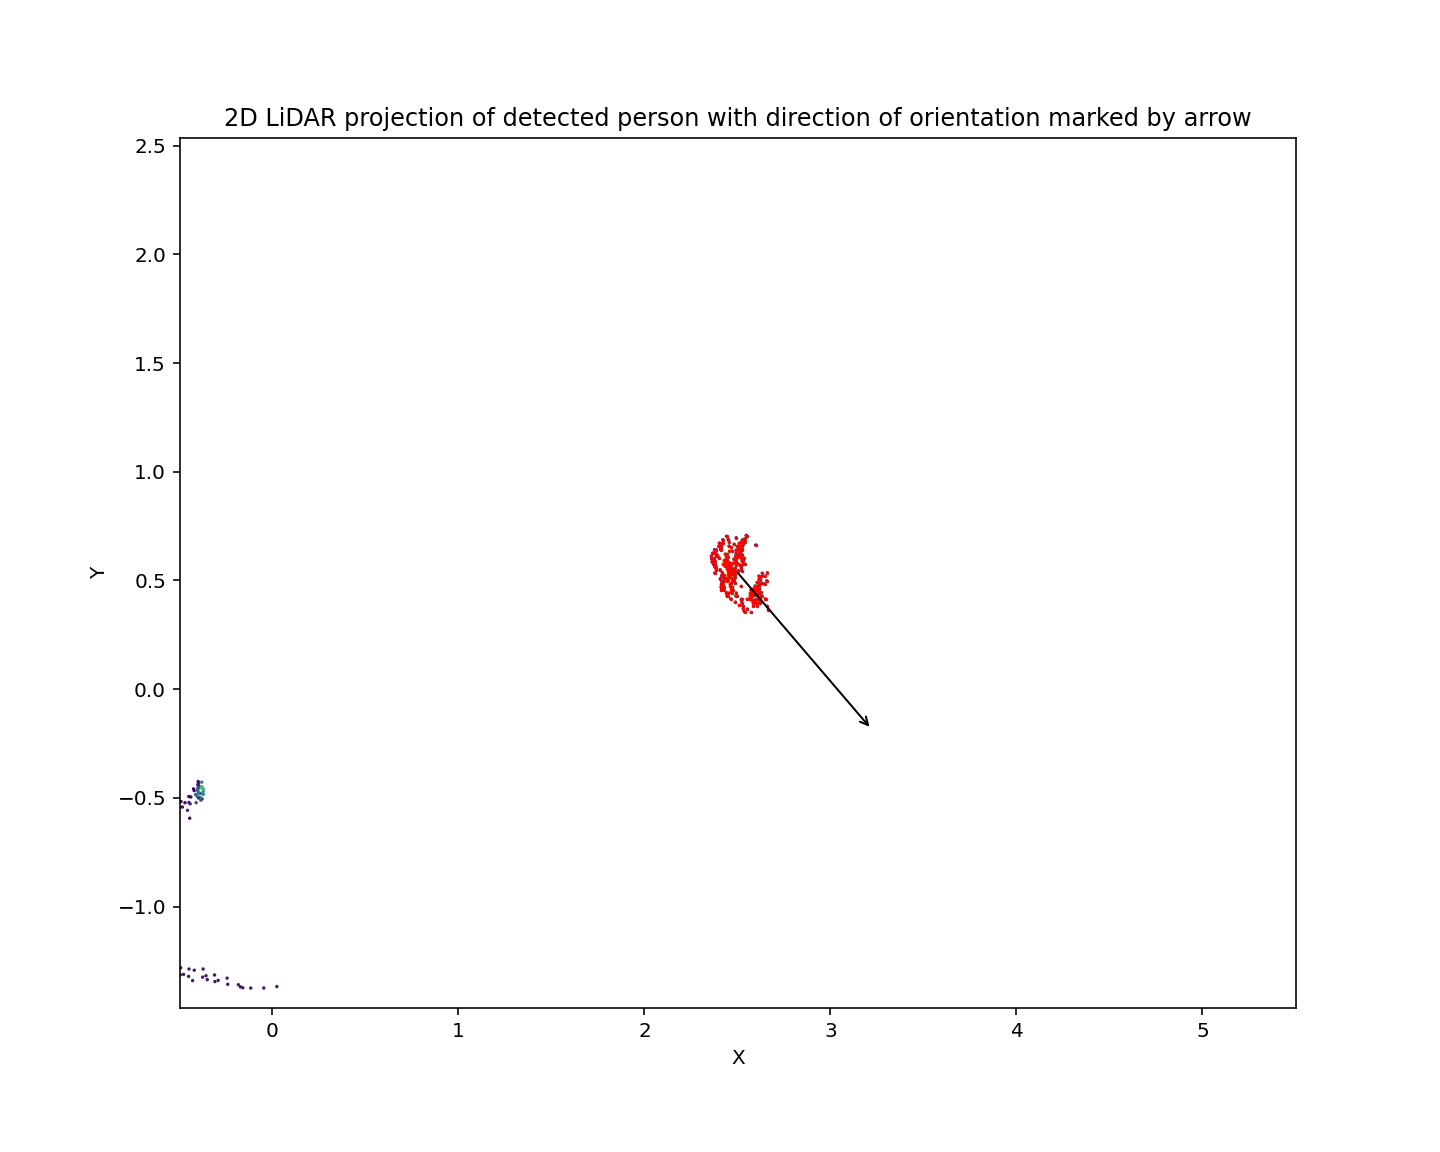

Orientation angle: -0.79 [rad] / -45.00 [deg]


In [49]:
%matplotlib notebook

# plot data
f2 = plt.figure(figsize=(10, 8))
plt.scatter(data[:, 0], data[:, 1], alpha=2, s=0.5, c=data[:, 3], cmap='viridis')
template = data[mask]
plt.scatter(template[:, 0], template[:, 1], s=0.5, c='r')
plt.xlabel('X')
plt.ylabel('Y')

center =centroid[0:2]
plt.xlim(center[0]-3, center[0]+3)
plt.ylim(center[1]-2, center[1]+2)
plt.title("2D LiDAR projection of detected person with direction of orientation marked by arrow")

# Return the arc tangens of y/x in radians from -pi to pi 
orient_angle, pca = calc_heading_angle(data, mask)
print('Orientation angle: {:.2f} [rad] / {:.2f} [deg]'.format(orient_angle, math.degrees(orient_angle)))
draw_vector(center, center + pca['components'][0])

plt.show()
# save_fig_in_folder(f2, path, keyword='orientation_scale_all_data_zoom2')

## Visualizations

### Using Mayavi
Inspired by authors of [Frustum PointNet](https://github.com/charlesq34/frustum-pointnets/blob/master/mayavi/viz_util.py).

#### Source code

In [21]:
from xvfbwrapper import Xvfb
vdisplay = Xvfb(width=1920, height=1080)
vdisplay.start()

from mayavi import mlab
mlab.init_notebook('ipy')

Notebook initialized with ipy backend.


In [75]:
def draw_lidar_simple(pc, color=None):
    ''' Draw lidar points. simplest set up. '''
    bgcolor = (1,1,1) # black, white=(0,0,0)
    fig = mlab.figure(figure=None, bgcolor=bgcolor, fgcolor=None, engine=None, size=(1600, 1000))
    if color is None: 
        color = pc[:,2]
    #draw points
        # draw points
    mlab.points3d(
        pc[:, 0],
        pc[:, 1],
        pc[:, 2],
        color,
        color=None,
        mode="point",
        colormap="spectral", # 'gnuplot'
        scale_factor=1,
        figure=fig,
    )
    #draw origin
    mlab.points3d(0, 0, 0, color=(1,1,1), mode='sphere', scale_factor=0.2)
    #draw axis
    axes=np.array([
        [2.,0.,0.,0.],
        [0.,2.,0.,0.],
        [0.,0.,2.,0.],
    ],dtype=np.float64)
    
    mlab.plot3d([0, axes[0,0]], [0, axes[0,1]], [0, axes[0,2]], color=(1,0,0), tube_radius=None, figure=fig)
    mlab.plot3d([0, axes[1,0]], [0, axes[1,1]], [0, axes[1,2]], color=(0,1,0), tube_radius=None, figure=fig)
    mlab.plot3d([0, axes[2,0]], [0, axes[2,1]], [0, axes[2,2]], color=(0,0,1), tube_radius=None, figure=fig)
    mlab.view(azimuth=180, elevation=70, focalpoint=[ 12.0909996 , -1.04700089, -2.03249991], distance=10.0, figure=fig)
    return fig

In [148]:
def draw_gt_boxes3d(gt_boxes3d, fig, color=(1,0,0), line_width=1, draw_text=True, text_scale=(0.8,0.8,0.8), color_list=None):
    ''' Draw 3D bounding boxes
    Args:
        gt_boxes3d: numpy array (n,8,3) for XYZs of the box corners
        fig: mayavi figure handler
        color: RGB value tuple in range (0,1), box line color
        line_width: box line width
        draw_text: boolean, if true, write box indices beside boxes
        text_scale: three number tuple
        color_list: a list of RGB tuple, if not None, overwrite color.
    Returns:
        fig: updated fig
    ''' 
    num = len(gt_boxes3d)
    for n in range(num):
        b = gt_boxes3d[n]
        if color_list is not None:
            color = color_list[n] 
        if draw_text: mlab.text3d(b[4,0], b[4,1], b[4,2], '%d'%n, scale=text_scale, color=color, figure=fig)
        for k in range(0,4):
            #http://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html
            i,j=k,(k+1)%4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)

            i,j=k+4,(k+1)%4 + 4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)

            i,j=k,k+4
            mlab.plot3d([b[i,0], b[j,0]], [b[i,1], b[j,1]], [b[i,2], b[j,2]], color=color, tube_radius=None, line_width=line_width, figure=fig)
    return fig

#### Testing

In [161]:
fig = draw_lidar_simple(data)
fig = draw_gt_boxes3d(corners3d_boxes, fig)

In [162]:
fig

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06@\x00\x00\x03\xe8\x08\x02\x00\x00\x00\t\x19\xa5\x…

In [78]:
name = 'test_LCAS_{}_top_view'.format(idx)
mlab.savefig(filename=os.path.join('../','plots/{}.png'.format(name)))

### Using Matplotlib
Code inspired by [this repo](https://github.com/navoshta/KITTI-Dataset/blob/master/kitti-dataset.ipynb).

#### source code

In [149]:
x_center, y_center = centroid[0:2]

In [98]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D


def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_bboxes_in_data(dataset, gt_boxes3d, plot=True, angle=False, label=None, bbox=None, outliers=None):
    """
    Displays the (ground truth) bounding boxes corresponding to the detection/label within the scatter 
    plot of the LiDAR data within 4 plots (one in 3D, and 3 projections).
    
    Parameters
    ----------
    dataset         : `raw` dataset.
    gt_boxes3d      : numpy nd array with bbox defined by its 8 vertices (in 3d spatial coordinates)
    """
    
    # Size of point markers in plots
    point_size = 0.3
    axes_str = ['X', 'Y', 'Z']
    if label is not None: 
        template_mask = np.where(label)
        background_mask = np.where(~label)
    else: 
        template_mask = None
        background_mask = None 

    def draw_point_cloud(ax, title, template_mask=None, background_mask=None, axes=[0, 1, 2], xlim3d=None, 
                         ylim3d=None, zlim3d=None, outliers=outliers, plot=plot):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        # Size of point markers in plots
        point_size = 0.5
        point_size_template = 2.0
        if not xlim3d and template_mask is not None: 
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', label='Positive label', markerfacecolor='r', markersize=10)
                ]
            if label is not None: 
                template = dataset[template_mask]
                background = dataset[background_mask]
                ax.scatter(*np.transpose(background[:, axes]), s=point_size, c=background[:, 3], cmap='viridis')
                ax.scatter(*np.transpose(template[:, axes]), s=point_size_template, c='r', marker='x')
            else: 
                ax.scatter(*np.transpose(dataset[:, axes]), s=point_size, c=dataset[:, 3], cmap='viridis')
            if outliers is not None: 
                ax.scatter(*np.transpose(outliers[:,axes]), s=point_size*10, c='b')
            ax.legend(handles=legend_elements, loc='upper right')
        else: 
            ax.scatter(*np.transpose(dataset[:, axes]), s=point_size, c=dataset[:, 3], cmap='viridis')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
#         User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        
        num = len(gt_boxes3d)
        for n in range(num):
            b = gt_boxes3d[n].T
            draw_box(ax, b, axes=axes, color='r')
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(10, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan',template_mask=template_mask,background_mask=background_mask, xlim3d=axes_limits[0],ylim3d=axes_limits[1], zlim3d=axes_limits[2])
    if plot:
        plt.show()
    
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(10, 15))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0)', 
        template_mask=template_mask,
        background_mask=background_mask,
        axes=[0, 2], # X and Z axes
        outliers=outliers
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0)', 
        template_mask=template_mask,
        background_mask=background_mask,
        axes=[0, 1], # X and Y axes
        outliers=outliers
    )
#     if (angle) & (label_mask != None) & (type(bbox)== np.ndarray):
#         _, pca_stats = calc_heading_angle(dataset, label_mask)
#         v = pca_stats['components'][0]
#         centroid = bbox[0:2]
#         draw_vector(centroid, centroid + v, ax=ax3[1])

    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0)',
        template_mask=template_mask,
        background_mask=background_mask,
        axes=[1, 2], # Y and Z axes
        outliers=outliers
    )
    if plot: 
        plt.show()
    return f, f2

#### Testing

In [90]:
%matplotlib notebook

In [111]:
plt.close('all')

In [ ]:
WALK = True
if not WALK:           # static datasets 
    axes_limits = [
        [dist-2, dist+2], # X axis range
        [-1, 2], # Y axis range
        [-0.5, 3]   # Z axis range
    ]
else: 
    # walking datasets
    x_center, y_center =centroid[0:2]
    axes_limits = [
        [x_center-3, x_center+3], # X axis range
        [y_center-2, y_center+2], # Y axis range
        [-0.5, 3]   # Z axis range
    ]

<IPython.core.display.Javascript object>


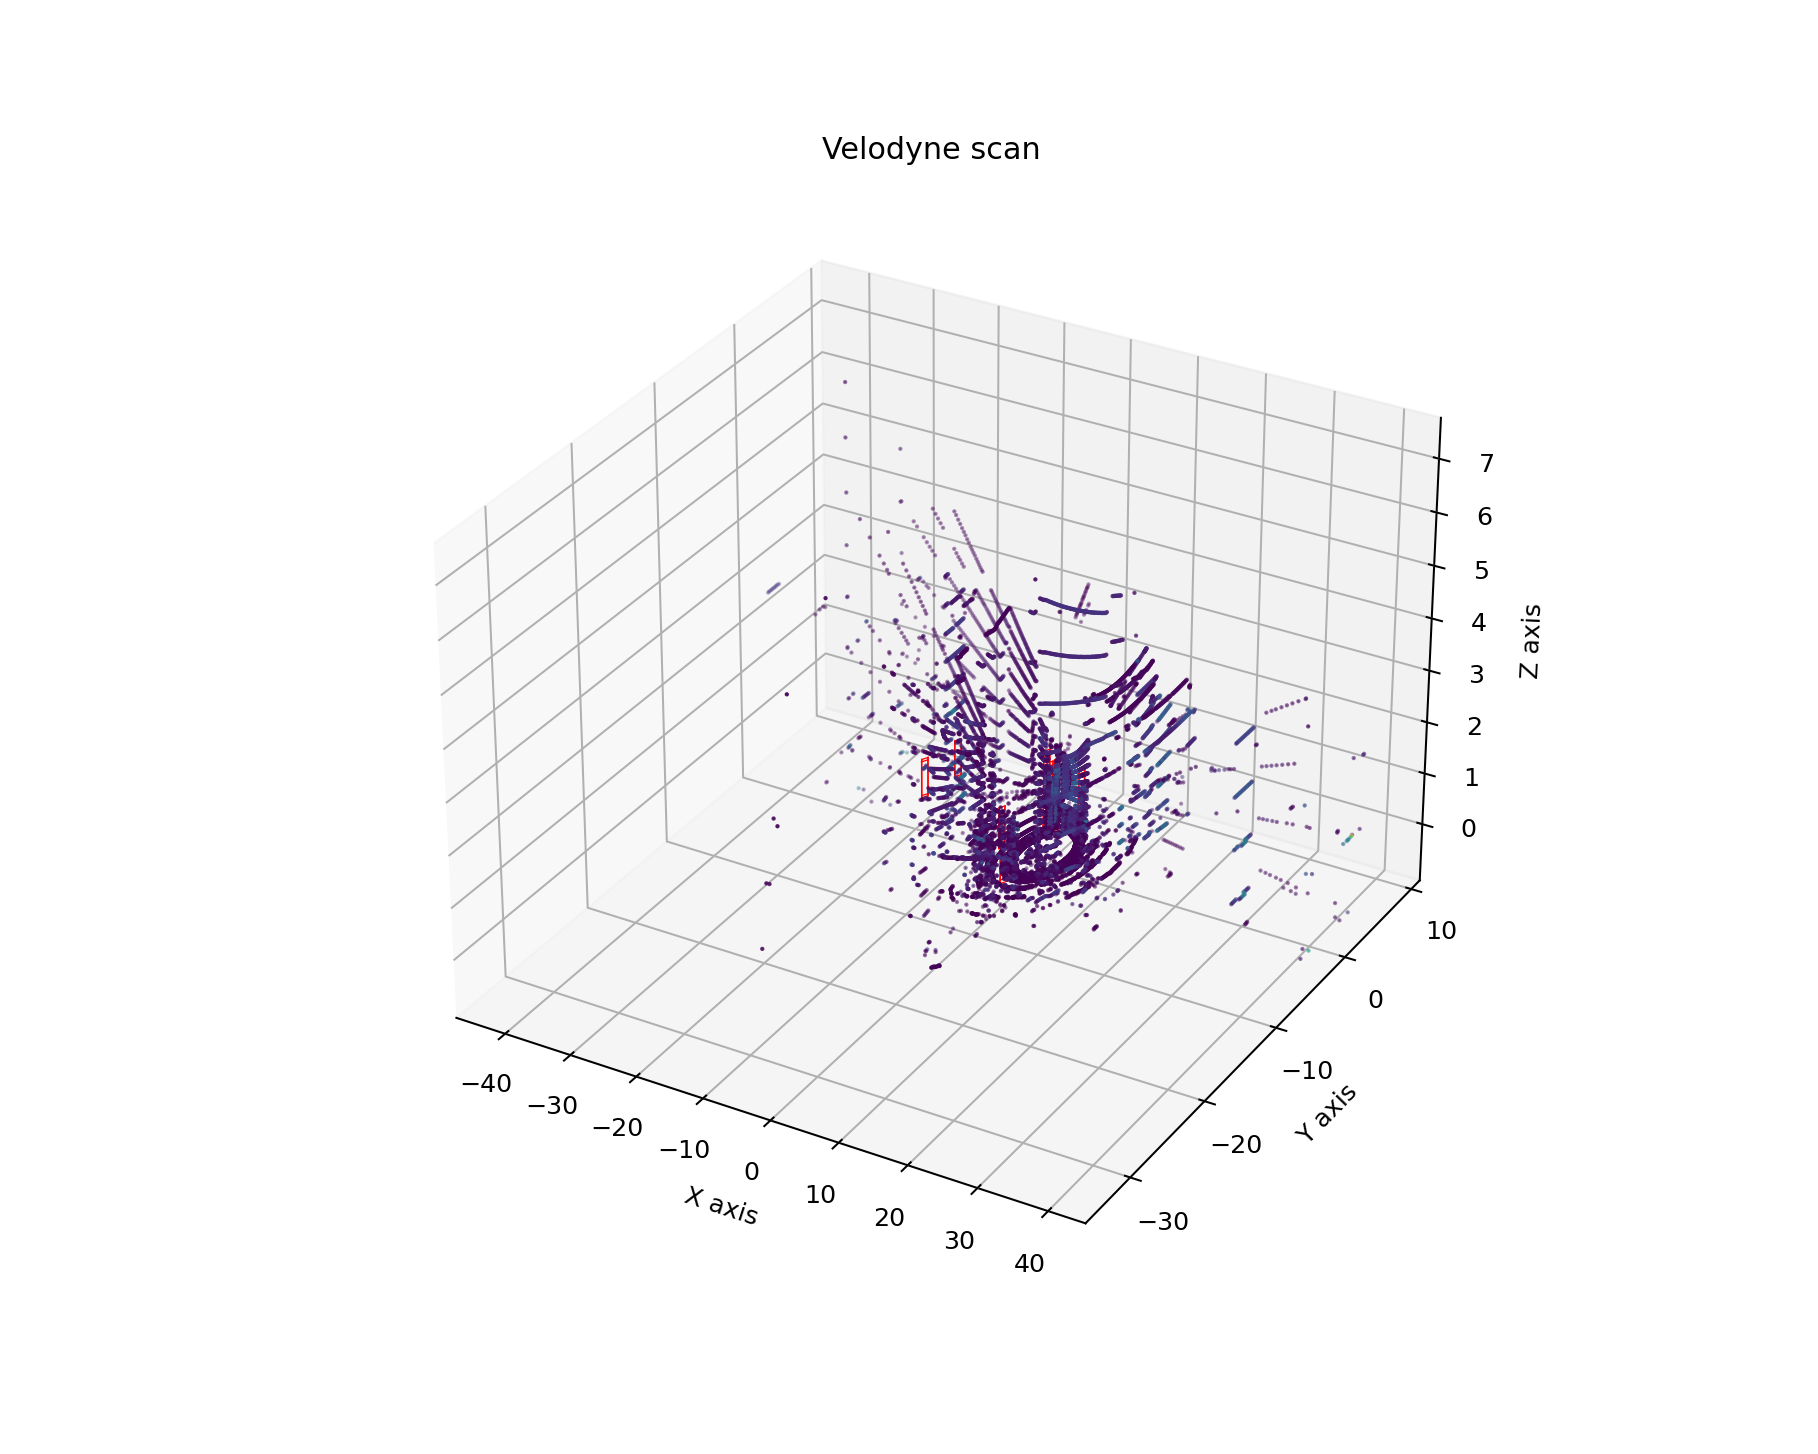

<IPython.core.display.Javascript object>


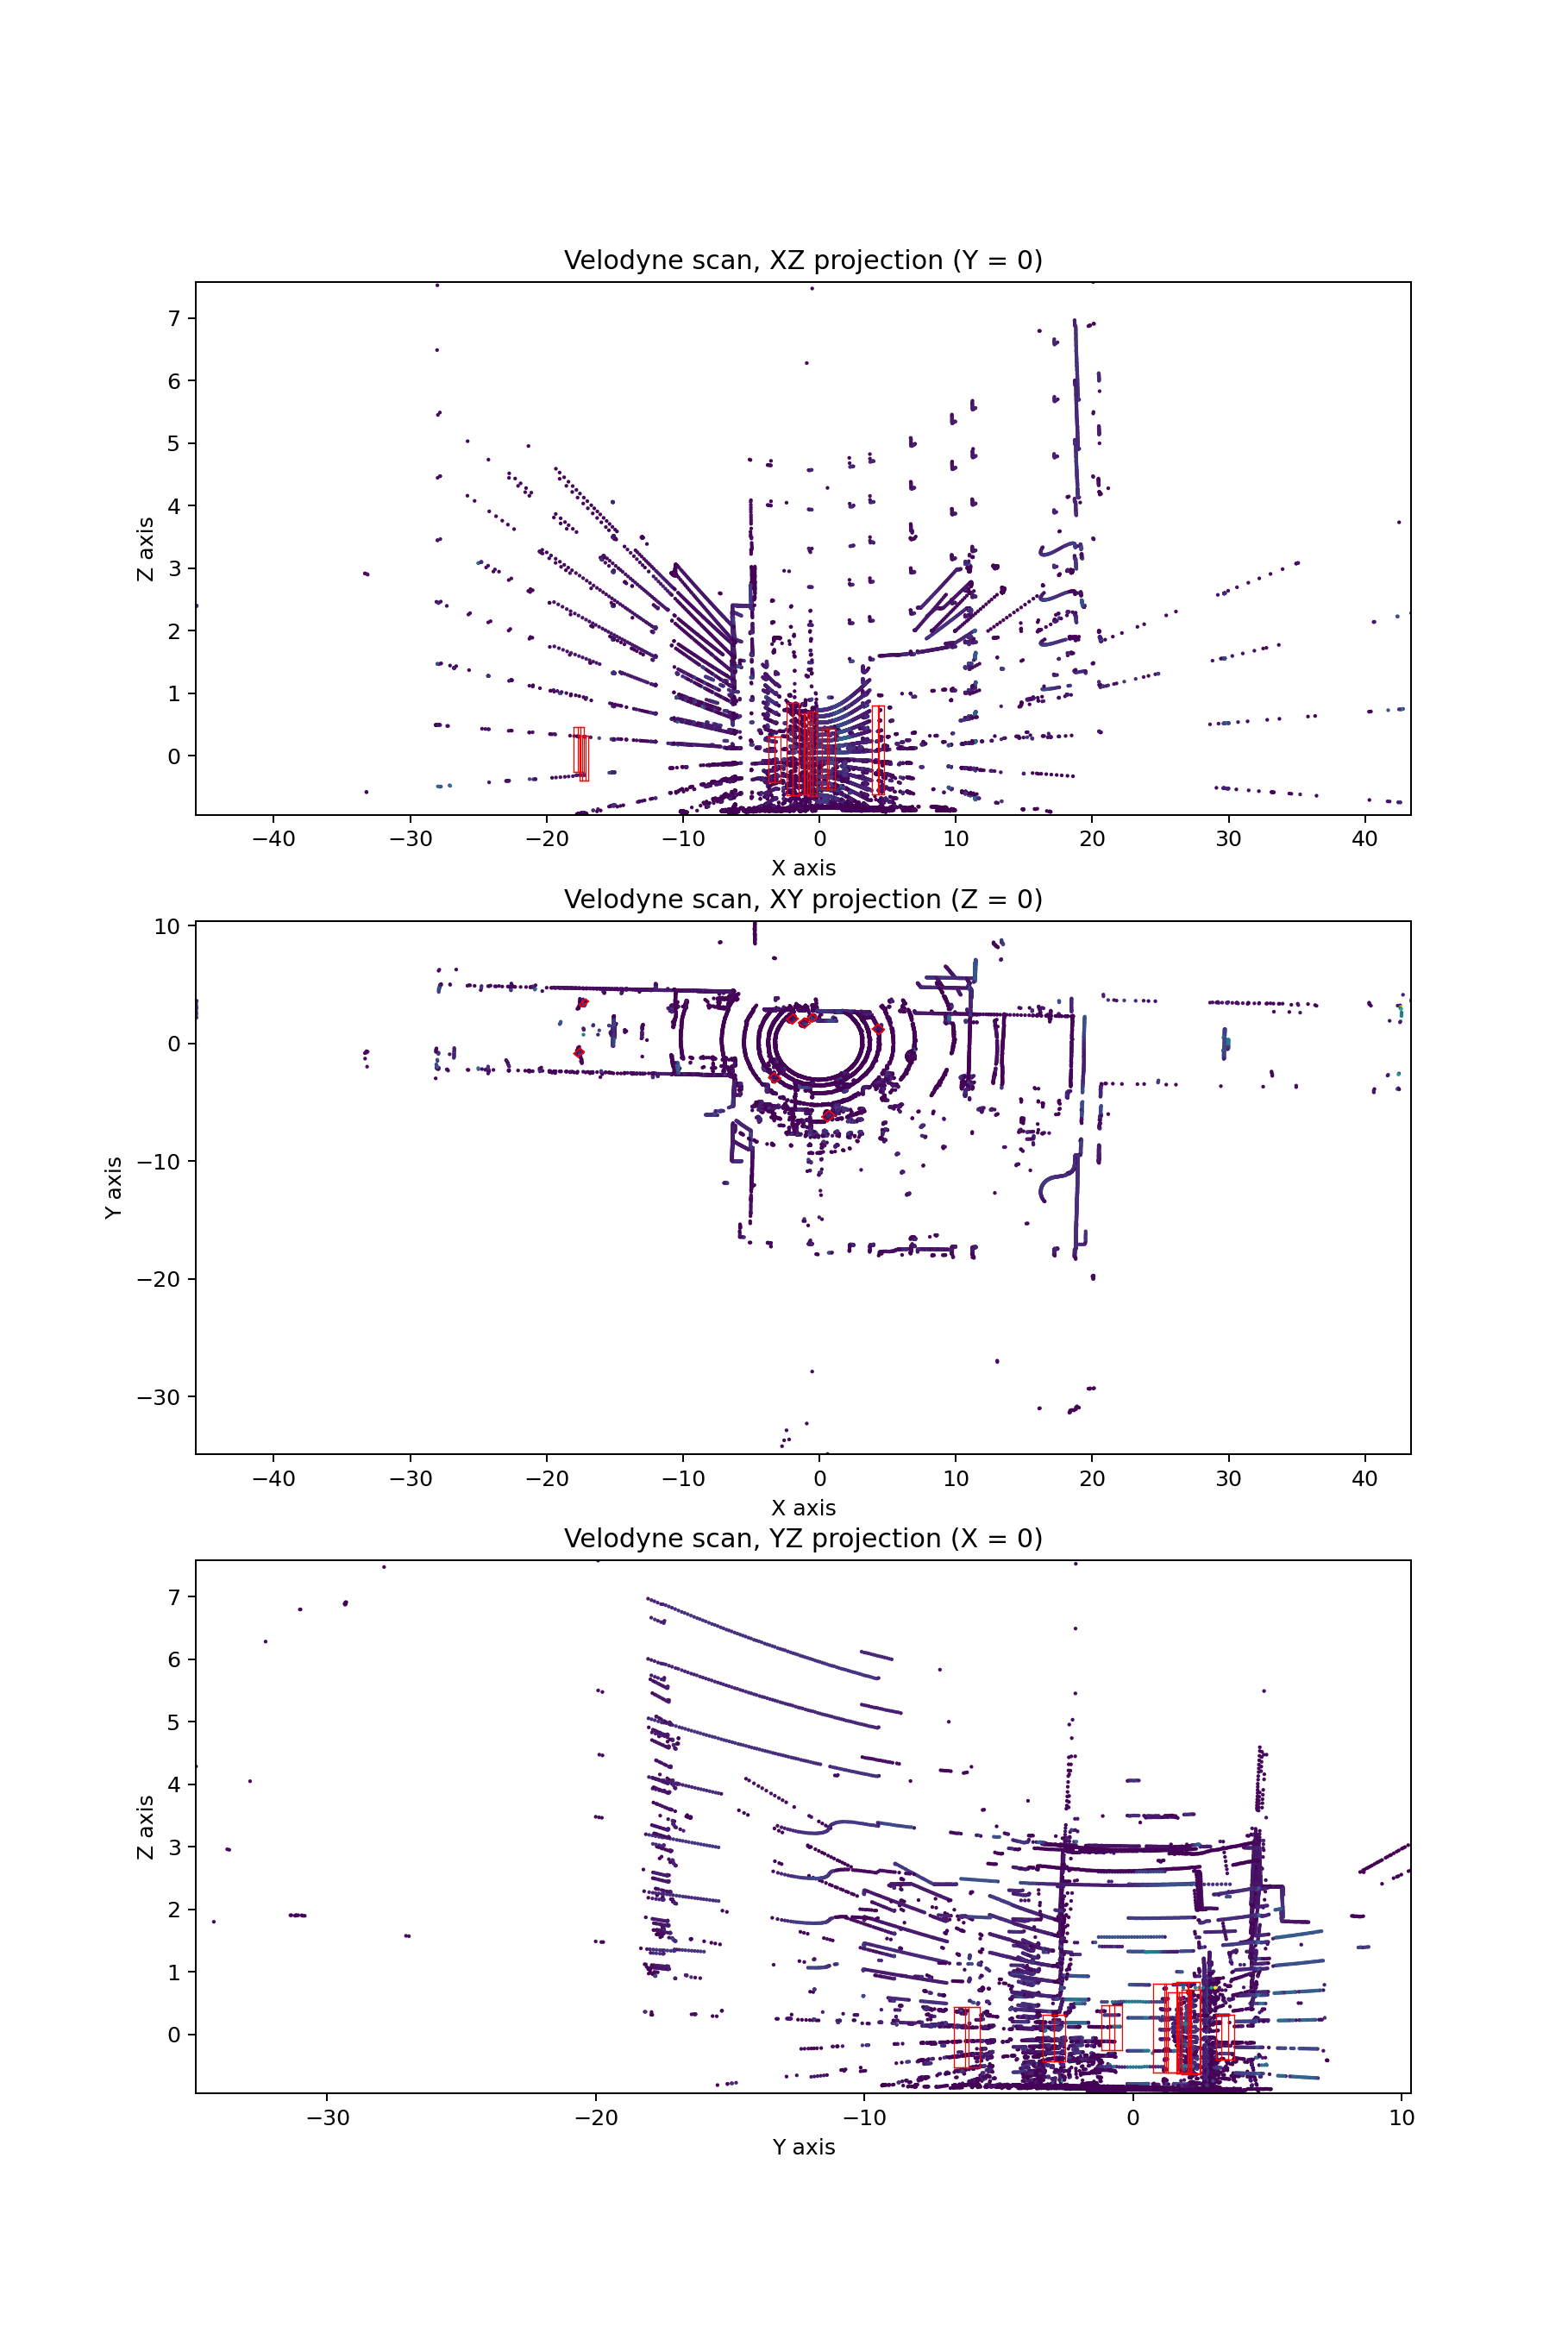

In [163]:
# LCAS: 
axes_limits = [
        [-15, 15], # X axis range
        [-15, 10], # Y axis range
        [-2, 3]   # Z axis range
    ]
x_max, x_min = np.max(data[:,0]), np.min(data[:,0])
y_max, y_min = np.max(data[:,1]), np.min(data[:,1])
z_max, z_min = np.max(data[:,2]), np.min(data[:,2])

axes_limits = [
    [x_min, x_max], # X axis range
    [y_min, y_max], # Y axis range
    [z_min, z_max]   # Z axis range
]
detections_proj, fig3d = display_bboxes_in_data(data, corners3d_boxes, angle=False)

In [164]:
detections_proj, fig3d = display_bboxes_in_data(data, corners3d_box, angle=False, label=label)

NameError: name 'corners3d_box' is not defined

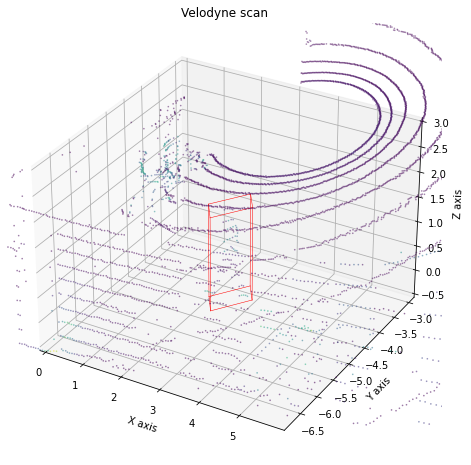

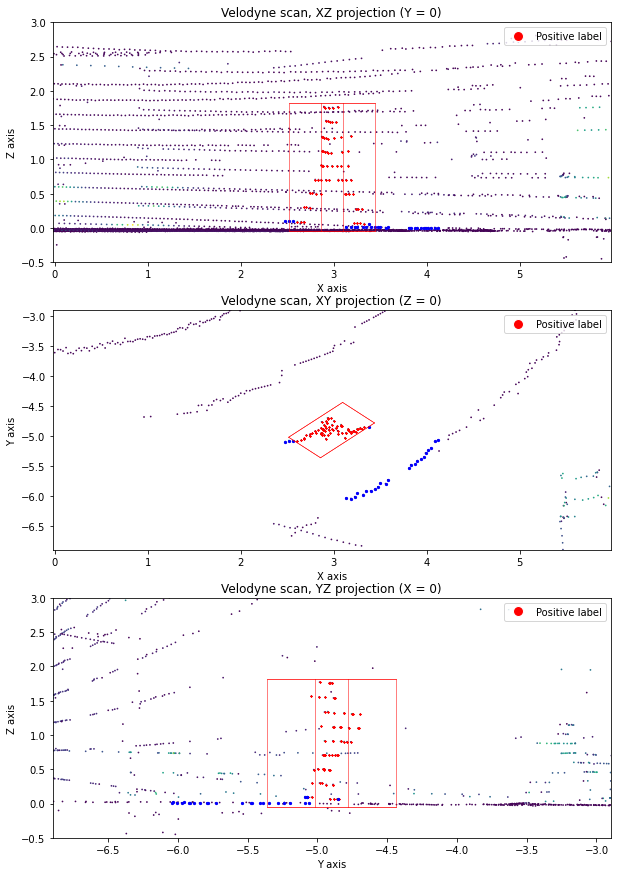

In [61]:
detections_proj, fig3d = display_bboxes_in_data(data, corners3d_box, angle=False, label=label, outliers=outliers)

In [123]:
save_path = '/home/crowdbot/master_lara/plots'

In [152]:
save_fig_in_folder(fig, save_path, name='walk_person_166_1_rot')

Saving figure in /home/crowdbot/master_lara/plots/plots


In [119]:
def save_fig_in_folder(fig, path, keyword=None, name=None):    
    SAVE_DIR = os.path.join(path, 'plots')
    print('Saving figure in {}'.format(SAVE_DIR))

    if not os.path.exists(SAVE_DIR):
#         pass # File has already been processed
#     else:
        os.makedirs(SAVE_DIR)
    if not name: 
        frame_name = str.rstrip(frame, '.h5')
        if keyword: 
            frame_name = frame_name + '_' + keyword
    else: 
        frame_name = name
    save_fig(fig, os.path.join(SAVE_DIR, frame_name), extension='.pdf')

## Validation Pipeline

In [ ]:
%matplotlib inline
for folder in sorted(os.listdir(DATA_DIR)):
    if folder.startswith('person'):
        print('---------------------')
        print(folder)
        path = os.path.join(DATA_DIR, folder) 
        data_files = [str(f) for f in sorted(os.listdir(path)) if f.endswith('.h5')] 
        dist = int(folder.split('_')[-1])
        
        # create subdirectory to save plots 
        SAVE_DIR = os.path.join(path, 'plots')
        if os.path.exists(SAVE_DIR):
            pass # File has already been processed
        else:
            os.makedirs(SAVE_DIR)
            
        # downsample frames 
        frame_sample = data_files[::20]
        print('Validating {}/{} frames'.format(len(frame_sample), len(data_files)))
        
        for frame in frame_sample: 
            # load data 
            f = os.path.join(path, frame)
            data, label, bbox = load_h5(f, bbox=True)
            centroid, h, w, l, angle = bbox[0:3], bbox[3], bbox[4], bbox[5], bbox[6]
            mask = np.where(label)
            template = data[mask]
            # calculate bounding box on labeled data 
            box8 = calc_3d_box(bbox)
            gt_box = np.reshape(box8, (-1,8,3))
            
#             detections_proj = display_bboxes_in_data(data, gt_box, plot=False)
            
            # static datasets 
            axes_limits = [
                [dist-2, dist+2], # X axis range
                [-1, 2], # Y axis range
                [-0.5, 3]   # Z axis range
            ]

            # walking datasets
#             x_center, y_center =centroid[0:2]
#             axes_limits = [
#                 [x_center-3, x_center+3], # X axis range
#                 [y_center-2, y_center+2], # Y axis range
#                 [-0.5, 3]   # Z axis range
#             ]
            
            detections_proj = display_bboxes_in_data(data, gt_box, label=label, bbox=bbox, plot=False)
            frame_name = str.rstrip(frame, '.h5')
            save_fig(detections_proj, os.path.join(SAVE_DIR, frame_name), extension='.png')
            plt.close('all')

In [64]:
anchor = [1.73, 0.6, 0.8] # h,w,l
save_path = '/home/crowdbot/master_lara/plots/wrong_annotations'

%matplotlib inline
for folder in sorted(os.listdir(DATA_DIR)):
    if folder.startswith('walk'):
        path = os.path.join(DATA_DIR, folder) 
        data_files = [str(f) for f in sorted(os.listdir(path)) if f.endswith('.h5')] 
        dist = int(folder.split('_')[-1])
        if dist <= 8: 
            print('---------------------')
            print(folder)
            print('Validating {} frames'.format(len(data_files)))

            height_list = []
            width_list = []
            length_list = []
            res_h_list = []
            res_w_list = []
            res_l_list = []
            total_res_list = []
            for frame in data_files: 
                # load data 
                f = os.path.join(path, frame)
                data, label, bbox = load_h5(f, bbox=True)
                centroid, h, w, l, angle = bbox[0:3], bbox[3], bbox[4], bbox[5], bbox[6]
                height_list.append(h)
                width_list.append(w)
                length_list.append(l)
                res_h = np.abs(h - anchor[0])
                res_w = np.abs(w - anchor[1])
                res_l = np.abs(l - anchor[2])
                total_res = np.sum([res_h, res_w, res_l])
                res_h_list.append(res_h)
                res_w_list.append(res_w)
                res_l_list.append(res_l)
                total_res_list.append(total_res)

                mask = np.where(label)
                template = data[mask]
                # calculate bounding box on labeled data 
                box8 = calc_3d_box(bbox)
                gt_box = np.reshape(box8, (-1,8,3))

                # static datasets 
#                 axes_limits = [
#                     [dist-2, dist+2], # X axis range
#                     [-1, 2], # Y axis range
#                     [-0.5, 3]   # Z axis range
#                 ]

#                 walking datasets
                x_center, y_center =centroid[0:2]
                axes_limits = [
                    [x_center-3, x_center+3], # X axis range
                    [y_center-2, y_center+2], # Y axis range
                    [-0.5, 3]   # Z axis range
                ]

                frame_name = str.rstrip(frame, '.h5')
                if total_res > 1.5: 
                    # create subdirectory to save plots 
                    SAVE_DIR = os.path.join(save_path, folder)
                    if os.path.exists(SAVE_DIR):
                        pass # File has already been processed
                    else:
                        os.makedirs(SAVE_DIR)
                    detections_proj, fig3d = display_bboxes_in_data(data, gt_box, label=label, bbox=bbox, plot=False)
                    save_fig(detections_proj, os.path.join(SAVE_DIR, frame_name), extension='.png')
                    save_fig(fig3d, os.path.join(SAVE_DIR, '3D_'+frame_name), extension='.png')
                    plt.close('all')
                    print('{}:{}'.format(frame_name, total_res))
                    
    #         print('{}: \navg h,w,l {}\navg res h,w,l {}\navg residual: {}'.format(
#                     frame_name, (np.mean(height_list), np.mean(width_list), np.mean(length_list)),
#                     (np.mean(res_h_list), np.mean(res_w_list), np.mean(res_l_list)), np.mean(total_res_list)))

---------------------
walk_backpack_person175_3
Validating 388 frames
frame346:1.8989024925231932
---------------------
walk_backpack_person175_4
Validating 465 frames
---------------------
walk_person166_1
Validating 371 frames
frame12:1.50743216753006
frame16:1.5004232275485994
frame292:1.511598621606827
frame304:1.5582605051994325
---------------------
walk_person166_2
Validating 448 frames
---------------------
walk_person166_3
Validating 581 frames
frame421:1.574984096288681
frame423:1.770165686607361
frame424:1.7481337237358094
frame427:1.601142888069153
---------------------
walk_person166_4
Validating 655 frames
frame457:2.423279838562012
---------------------
walk_person166_5
Validating 772 frames
---------------------
walk_person166_6
Validating 757 frames
---------------------
walk_person166_7
Validating 745 frames
frame458:2.1409672546386718
frame460:1.5808452117443086
frame479:1.586770884990692
frame480:1.5244195985794067
frame481:1.7286581921577453
frame482:1.614897840023

In [167]:
anchor = [1.73, 0.6, 0.8] # h,w,l
save_path = '/home/crowdbot/master_lara/plots/'

# print all frames of given recording
%matplotlib inline
for folder in sorted(os.listdir(DATA_DIR)):
    if folder.startswith('walk_person166_3'):
        path = os.path.join(DATA_DIR, folder) 
        data_files = [str(f) for f in sorted(os.listdir(path)) if f.endswith('.h5')] 
        dist = int(folder.split('_')[-1])
        if dist <= 8: 
            print('---------------------')
            print(folder)
            print('Validating {} frames'.format(len(data_files)))
            # create subdirectory to save plots 
            SAVE_DIR = os.path.join(save_path, folder)
            if os.path.exists(SAVE_DIR):
                pass # File has already been processed
            else:
                os.makedirs(SAVE_DIR)

            for frame in data_files: 
                # load data 
                f = os.path.join(path, frame)
                data, label, bbox = load_h5(f, bbox=True)
                centroid, h, w, l, angle = bbox[0:3], bbox[3], bbox[4], bbox[5], bbox[6]

                # calculate bounding box on labeled data 
                box8 = calc_3d_box(bbox)
                gt_box = np.reshape(box8, (-1,8,3))

                # static datasets 
#                 axes_limits = [
#                     [dist-2, dist+2], # X axis range
#                     [-1, 2], # Y axis range
#                     [-0.5, 3]   # Z axis range
#                 ]

#                 walking datasets
                x_center, y_center =centroid[0:2]
                axes_limits = [
                    [x_center-3, x_center+3], # X axis range
                    [y_center-2, y_center+2], # Y axis range
                    [-0.5, 3]   # Z axis range
                ]

                frame_name = str.rstrip(frame, '.h5')
                    
                detections_proj, fig3d = display_bboxes_in_data(data, gt_box, label=label, bbox=bbox, plot=False)
                save_fig(detections_proj, os.path.join(SAVE_DIR, frame_name), extension='.png')
                save_fig(fig3d, os.path.join(SAVE_DIR, '3D_'+frame_name), extension='.png')
                plt.close('all')

---------------------
walk_person166_3
Validating 581 frames
frame0:0.7824122655391693
frame1:0.872902010679245
frame10:0.831068252325058
frame100:0.7897393333911896
frame101:0.8961353528499604
frame102:0.8309744226932526
frame103:0.7693533229827881
frame104:0.9273696768283844
frame10:0.9758732545375824
frame106:0.8455156910419465
frame107:0.8161303627490998
frame108:0.861548684835434
frame109:0.7838239896297455
frame11:0.88356724858284
frame110:0.7729286777973176
frame111:0.6403592872619629
frame112:0.6515547680854797
frame113:0.6829453754425049
frame114:0.734535847902298
frame11:0.7221745896339417
frame116:0.8030814754962922
frame117:0.8627608644962311
frame118:0.8167876529693604
frame119:0.9015384542942048
frame12:0.9181081998348236
frame120:0.8481517064571381
frame121:0.86155637383461
frame122:0.6669805574417115
frame123:0.6382163095474244
frame124:0.5951921987533569
frame12:0.7578133690357208
frame126:0.7686306583881378
frame127:0.7218301045894623
frame128:0.7747592675685883
frame

frame364:0.6536499786376954
frame36:0.7300153303146363
frame366:0.7783432531356812
frame367:0.7214398908615113
frame368:0.7249762344360352
frame369:0.7042129564285279
frame37:0.7335766899585724
frame370:0.6622860956192017
frame371:0.5894038009643555
frame372:0.607684497833252
frame373:0.6241595792770386
frame374:0.64863694190979
frame37:0.6854119646549225
frame376:0.6519220221042633
frame377:0.7195872414112091
frame378:0.6246433782577515
frame379:0.7248316335678101
frame38:0.8629207956790924
frame380:0.823839716911316
frame381:0.8029857206344605
frame382:0.8671142387390137
frame383:0.9262662756443024
frame384:0.9135034906864167
frame38:0.8357436287403107
frame386:0.6865948963165284
frame387:0.6343120861053467
frame388:0.5810747194290161
frame389:0.5627421188354492
frame39:0.9033860611915588
frame390:0.6216430711746216
frame391:0.6680107760429382
frame392:0.7033118057250977
frame393:0.7300996232032776
frame394:0.7091850686073303
frame39:0.7572174894809723
frame396:0.8300093042850495
fra

## Data Overview

In [28]:
data.shape

(4912377, 6)

In [29]:
data.head()

,rosbagTimestamp,x,y,z,intensity,time
0,1590775583702332952,-1.055055,1.817870,-0.563190,6.0,-0.048886
1,1590775583702332952,-3.424826,5.905756,0.119165,42.0,-0.048884
2,1590775583702332952,-1.224575,2.112502,-0.563727,4.0,-0.048882
3,1590775583702332952,-3.431576,5.924548,0.358815,26.0,-0.048879
4,1590775583702332952,-1.482979,2.562392,-0.575480,1.0,-0.048877


In [43]:
# investigate value ranges
x_max, x_min = np.max(data.x), np.min(data.x)
y_max, y_min = np.max(data.y), np.min(data.y)
z_max, z_min = np.max(data.z), np.min(data.z)
intensity_max, intensity_min = np.max(data.intensity), np.min(data.intensity)

print('x_max: {:.3f}, x_min: {:.3f}'.format(x_max, x_min))
print('y_max: {:.3f} y_min: {:.3f}'.format(y_min, y_max))
print('z_max: {:.3f}, z_min: {:.3f}'.format(z_max, z_min))
print('intensity_max: {:.3f}, intensity_min: {:.3f}'.format(intensity_max, intensity_min))
print('\nNumber of points: {}'.format(data.shape[0]))

x_max: 49.444, x_min: -4.745
y_max: -37.609 y_min: 35.406
z_max: 4.689, z_min: -1.359
intensity_max: 131.000, intensity_min: 0.000

Number of points: 3908367


In [95]:
data.z.mean()

0.46101681533919564

## Backup

### Create PCD Files 

In [30]:
timesteps = data.rosbagTimestamp.unique()
path = bag_dir + '/' + dropdown.value
os.mkdir(path)
thresh = 0 
for i,t in enumerate(timesteps):    
    # Analyze pointcloud from timestamp chosen above 
    oneframe_data = data[data.rosbagTimestamp == t].reset_index(drop=True)
    # Rotate & translate points to compensate for LiDAR tilt angle 
    oneframe_data_trans = df_apply_rot(oneframe_data, quat, return_full_df=True)
    oneframe_data_trans = translate_height(oneframe_data_trans, z_trans)
    # Remove ground points
    oneframe_data_trans_no_floor = remove_ground_points(oneframe_data_trans, thresh)
    # Filter by radius 
    oneframe_data_trans_no_floor = add_polar_coord(oneframe_data_trans_no_floor)
    label_mask = oneframe_data_trans_no_floor.r.between(*interval)
    oneframe_data_trans_no_floor['label'] = label_mask
    # Create template 
    template = oneframe_data_trans_no_floor[oneframe_data_trans_no_floor.label].reset_index(drop=True)
    # Save as binary matrix file for annotation
    temp_frame = template[['x','y','z']].copy()
#     temp = temp_frame.to_numpy(dtype='float32').astype('float32')
    temp = temp_frame.to_numpy()
    p = pcl.PointCloud(np.array(temp, dtype=np.float32))
    p.to_file(path + '/frame_{}_{}.pcd'.format(i,t))
#     temp.tofile(path + '/frame{}.bin'.format(t),  format="%f")

### Visualizations

#### 3D Plot using matplotlib

In [ ]:
%matplotlib notebook

In [ ]:
plot_pointcloud3d(start)

#### 3D Plot using pptk
See documentation [here](https://heremaps.github.io/pptk/index.html). 
Example screenshot of interactive 3D visualzation:
<img src="files/pcl_1585676368204491882.png">

In [113]:
import pptk

In [43]:
v = pptk.viewer(template_no_floor[['x', 'y', 'z']]) 
v.attributes(template_no_floor['intensity'])
v.set(point_size=0.01)

In [ ]:
v.capture('/home/brudermueller/Downloads/pcl_{}.png'.format(str(timesteps[0])))

In [139]:
# take only every 40th timestep
subsample = timesteps[::40]

In [ ]:
pcl = data[data.rosbagTimestamp == timesteps[150]].reset_index()
pcl = df_apply_rot(pcl)
pcl = remove_ground_points(pcl, -0.38)
pcl.head()
pcl = pcl[(pcl.x.between(2.9, 3.5)) & (pcl.y.between(-1, 2))]
v = pptk.viewer(pcl[['x', 'y', 'z']]) 
v.attributes(pcl['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=7)   

In [55]:
# save screenshot of lidar 3D plot for each timestep 
import time
templates = data_trans[data_trans.label].reset_index(drop=True)
# templates = data_trans_no_floor[data_trans_no_floor.label].reset_index(drop=True)

# templates = remove_ground_points(templates, 0)
for i,t in enumerate(timesteps[::10]): 
    pcl = templates[templates.rosbagTimestamp == t].reset_index(drop=True)
    if pcl.empty:
        print t
        continue
    v = pptk.viewer(pcl[['x', 'y', 'z']]) 
    v.attributes(pcl['intensity'])
    v.set(point_size=0.01, lookat=(4.5, -0.5, -1), r=10)    
    time.sleep(2)
#     v.capture('/home/brudermueller/Downloads/med/pcl_templates_{}_{}.png'.format(dropdown.value, i))
#     time.sleep(2)
    v.close()

In [ ]:
v = pptk.viewer(start_ground[['x', 'y', 'z']]) 
v.attributes(start_ground['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)

In [ ]:
v = pptk.viewer(start[['x', 'y', 'z']]) 
v.attributes(start['intensity'])
v.set(point_size=0.001, lookat=(5, 0.5, 1.5), r=10)